<a href="https://colab.research.google.com/github/KamoTaueatsoala/AI-mini-project/blob/main/Irrigation_minimised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

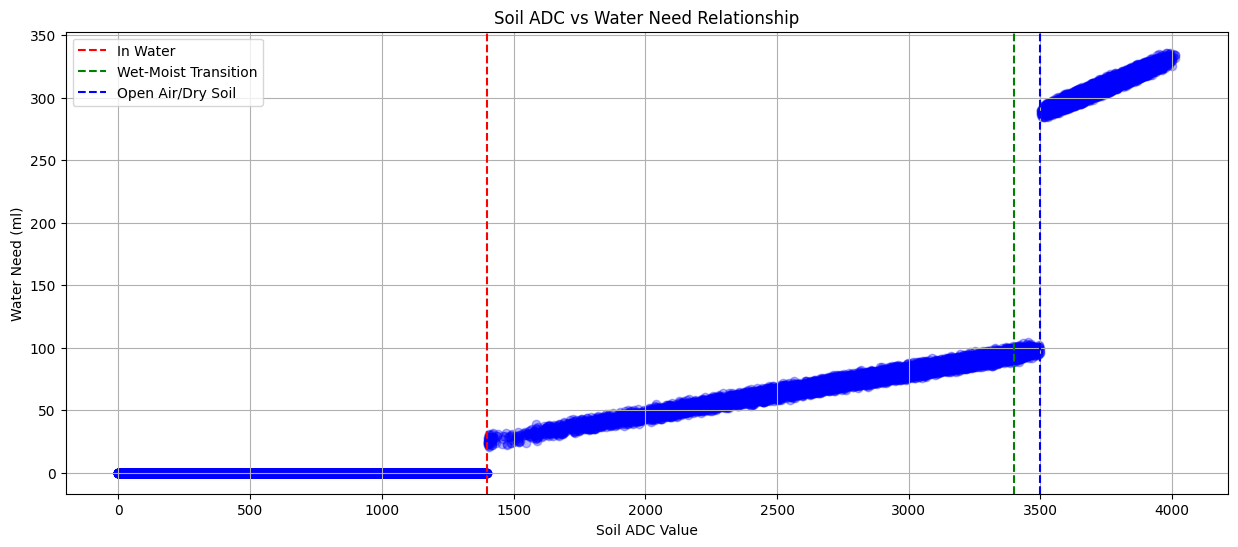

Epoch 1/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 56.5809 - mae: 57.0110 - val_loss: 15.5120 - val_mae: 15.8785 - learning_rate: 0.0050
Epoch 2/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 16.1712 - mae: 16.5249 - val_loss: 15.7154 - val_mae: 16.0611 - learning_rate: 0.0050
Epoch 3/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 14.6588 - mae: 15.0018 - val_loss: 12.6191 - val_mae: 12.9662 - learning_rate: 0.0050
Epoch 4/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 12.9967 - mae: 13.3329 - val_loss: 13.1871 - val_mae: 13.5218 - learning_rate: 0.0050
Epoch 5/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 11.4643 - mae: 11.7932 - val_loss: 16.2010 - val_mae: 16.5304 - learning_rate: 0.0050
Epoch 6/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.5267 - mae: 9.8426 - val_loss: 8.0522 - val_mae: 8.3813 - learning_rate: 0.0050
Epoch 7/200
399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 6.6560 - mae: 6.9592 - val_loss: 5.3132 - val_mae: 5.6010 - l

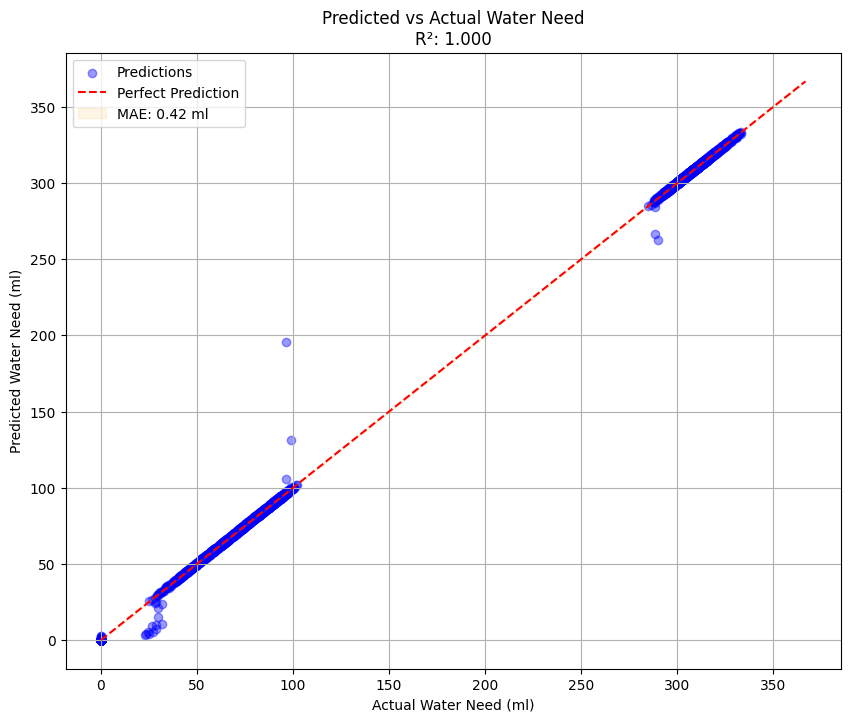

Saved artifact at '/tmp/tmpyw8fznn9'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 6), dtype=tf.float32, name='keras_tensor_11')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  138997024232400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138997024243152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138997024234320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138997024231056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138997024242960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138997024242384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138997024242192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138997024237008: TensorSpec(shape=(), dtype=tf.resource, name=None)

Model size: 8800 bytes


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


0

In [4]:
# -*- coding: utf-8 -*-
"""irrigation_minimized_improved.ipynb"""

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Constants
MAX_SENSOR_VALUE = 4095
MIN_TEMP = 10.0
MAX_TEMP = 45.0
MAX_HUMIDITY = 100.0

# Soil moisture thresholds
IN_WATER_THRESHOLD = 1400
WET_MOIST_THRESHOLD = 3400
OPEN_AIR_MIN = 3500
OPEN_AIR_MAX = 3699

def generate_water(soil, temp, humidity, hour):
    """Simplified water calculation for parsley in small pots"""
    if soil <= IN_WATER_THRESHOLD:
        return 0.0
    soil_norm = (soil - IN_WATER_THRESHOLD) / (OPEN_AIR_MAX - IN_WATER_THRESHOLD)
    base_water = 50.0 + soil_norm * 100.0 if soil >= OPEN_AIR_MIN else 10.0 + soil_norm * 40.0
    temp_adj = 8.0 * ((temp - MIN_TEMP) / (MAX_TEMP - MIN_TEMP))
    hum_adj = 4.0 * (1 - (humidity / MAX_HUMIDITY))
    hour_adj = 1.5 * np.cos((hour - 14) * np.pi / 12)
    water_ml = base_water * 2.0 + temp_adj + hum_adj + hour_adj
    return max(0, water_ml)

def generate_features(soil, temp, humidity, hour):
    """Features with key interactions for better accuracy"""
    temp_norm = (temp - MIN_TEMP) / (MAX_TEMP - MIN_TEMP)
    hum_norm = humidity / MAX_HUMIDITY
    soil_norm = (soil - IN_WATER_THRESHOLD) / (OPEN_AIR_MAX - IN_WATER_THRESHOLD)
    return np.column_stack((
        soil_norm,
        temp_norm,
        hum_norm,
        np.cos(hour * np.pi / 12),
        soil_norm * temp_norm,
        soil_norm * hum_norm
    ))

def load_data():
    """Generate training data with balanced soil distribution"""
    np.random.seed(42)
    num_samples = 30000
    soil = np.concatenate([
        np.random.randint(0, IN_WATER_THRESHOLD, num_samples//3),
        np.random.triangular(IN_WATER_THRESHOLD, WET_MOIST_THRESHOLD, OPEN_AIR_MIN, num_samples//3),
        np.random.triangular(OPEN_AIR_MIN, OPEN_AIR_MAX, OPEN_AIR_MAX+300, num_samples//3)
    ])[:num_samples]
    temp = np.clip(np.random.normal(25, 10, num_samples), MIN_TEMP, MAX_TEMP)
    humidity = np.clip(np.random.normal(50, 25, num_samples), 10, MAX_HUMIDITY)
    hour = np.random.randint(0, 24, num_samples)
    soil = np.clip(soil + np.random.normal(0, 15, size=soil.shape).astype(int), 0, MAX_SENSOR_VALUE)
    water = np.array([generate_water(s, t, h, hr) for s, t, h, hr in zip(soil, temp, humidity, hour)])

    # Soil ADC vs Water Need plot
    plt.figure(figsize=(15, 6))
    plt.scatter(soil, water, alpha=0.3, c='blue')
    plt.axvline(IN_WATER_THRESHOLD, color='r', linestyle='--', label='In Water')
    plt.axvline(WET_MOIST_THRESHOLD, color='g', linestyle='--', label='Wet-Moist Transition')
    plt.axvline(OPEN_AIR_MIN, color='b', linestyle='--', label='Open Air/Dry Soil')
    plt.title("Soil ADC vs Water Need Relationship")
    plt.xlabel("Soil ADC Value")
    plt.ylabel("Water Need (ml)")
    plt.legend()
    plt.grid(True)
    plt.show()

    X = generate_features(soil, temp, humidity, hour)
    y = water.reshape(-1, 1)
    return train_test_split(X, y, test_size=0.15, random_state=42)

# Load data
X_train, X_test, y_train, y_test = load_data()

# Enhanced model for better accuracy
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(6,)),
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='linear')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=0.005, clipnorm=1.0),  # Added gradient clipping
        loss=tf.keras.losses.Huber(delta=1.0),
        metrics=['mae']
    )
    return model

model = create_model()

# Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

# Train model
history = model.fit(
    X_train, y_train,
    epochs=200,  # Increased for finer convergence
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Evaluation
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nModel Metrics:")
print(f"- MAE: {mae:.4f} ml")
print(f"- R²: {r2:.4f}")

# Actual vs Predicted plot
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.4, c='blue', label='Predictions')
max_water = max(np.max(y_test), np.max(y_pred)) * 1.1
plt.plot([0, max_water], [0, max_water], 'r--', label='Perfect Prediction')
plt.fill_between([0, max_water], [0-mae, max_water-mae], [0+mae, max_water+mae],
                 color='orange', alpha=0.1, label=f'MAE: {mae:.2f} ml')
plt.xlabel('Actual Water Need (ml)')
plt.ylabel('Predicted Water Need (ml)')
plt.title(f'Predicted vs Actual Water Need\nR²: {r2:.3f}')
plt.legend()
plt.grid(True)
plt.show()

# TFLite conversion with full-integer quantization
def representative_dataset():
    for _ in range(100):
        yield [X_test[np.random.randint(0, len(X_test))].astype(np.float32)]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_model = converter.convert()

# Save TFLite model
with open('water_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("\nModel size:", len(tflite_model), "bytes")

# Generate C header
from subprocess import call
call("echo 'const unsigned char model[] = {' > model.h", shell=True)
call("cat water_model.tflite | xxd -i >> model.h", shell=True)
call("echo '};' >> model.h", shell=True)
call("echo 'const unsigned int model_len = sizeof(model);' >> model.h", shell=True)